In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import os
import re
from pathlib import Path

plt.style.use("ggplot")

In [75]:
def get_latest(directory, pattern = "*"):
    fs = []
    for f in directory.glob(pattern):
        files = list(f.glob("*.out"))
        newest_path = max(files, key=os.path.getmtime)
        fs.append(newest_path)
        for p in files:
            if p != newest_path:
                p.unlink()
    return fs

def get_time_and_mem_from_file(contents: str):
    for line in map(str.strip, contents.splitlines()):
        if line.startswith("Max Memory"):
            m = re.search(r"\d+\.?\d*", line)
            if not m:
                mb = None
            else:
                mb = float(m.group())
        elif line.startswith("CPU time"):
            m = re.search(r"\d+\.?\d*", line)
            if not m:
                sec = None
            else:
                sec = float(m.group())
    return sec, mb

In [78]:
build_rules = {"drprg_build", "create_popn_msas", "create_popn_pre_msas", "index_popn_prg", "make_popn_prgs"}
predict_rules = {"drprg_predict", "mykrobe"}
required_rules = build_rules.union(predict_rules)

In [79]:
logdir = Path("../../logs/cluster/")
rules = set()
data = []
for p in logdir.glob("*"):
    if p.is_dir():
        rule = p.name
        if rule not in predict_rules:
            continue
        fs = get_latest(p, "*sample*")
        for f in fs:
            contents = f.read_text()
            if "Successfully completed" not in contents:
                continue
            sec, mb = get_time_and_mem_from_file(contents)
            sample = f.parts[-2].split("=")[-1]
            tech = f.parts[-2].split("=")[1].split(".")[0]
            data.append((rule.split("_")[0], sample, tech, sec, mb))

In [80]:
df = pd.DataFrame(data, columns=["tool", "sample", "tech", "time", "memory"])

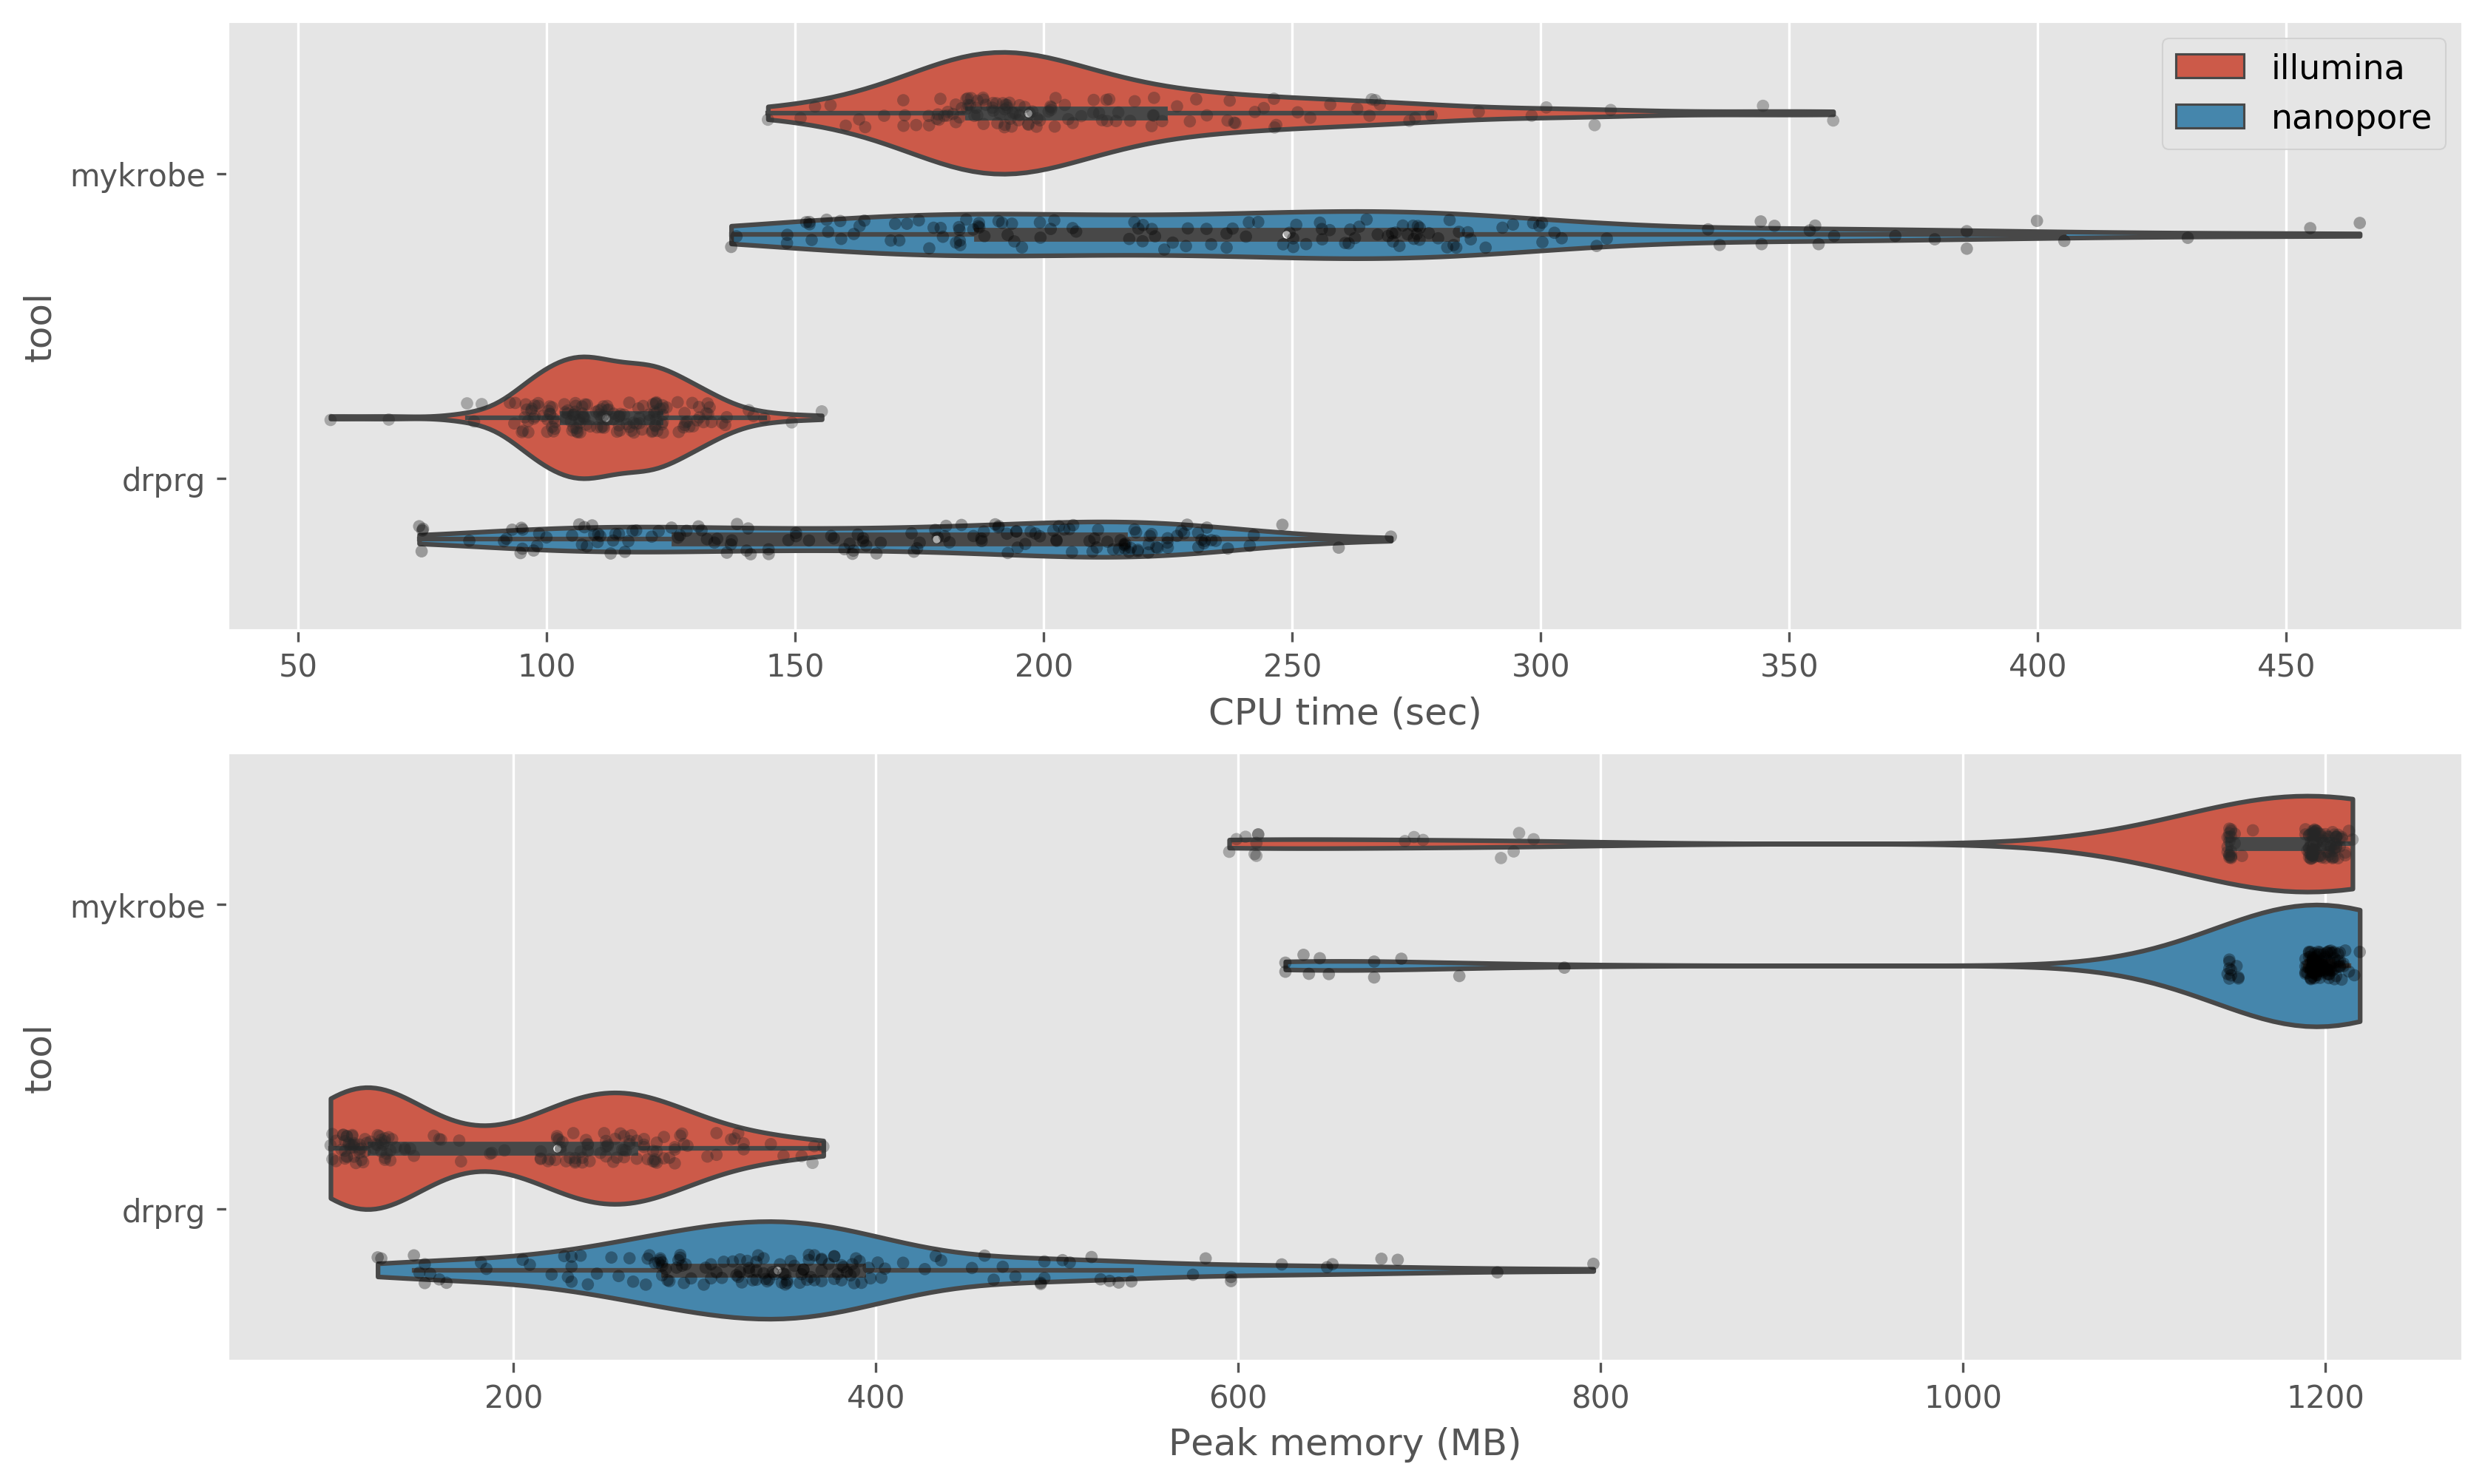

In [109]:
fig, axes = plt.subplots(nrows=2, dpi=300, figsize=(13, 8))
for ax, x, label in zip(axes.flatten(), ["time", "memory"], ["CPU time (sec)", "Peak memory (MB)"]):
    sns.violinplot(data=df, x=x, y="tool", ax=ax, cut=0, hue="tech")
#     sns.boxenplot(data=df, x=x, y="tool", ax=ax, )
    sns.stripplot(data=df, x=x, y="tool", ax=ax, color="black", hue="tech",dodge=True, alpha=0.33, size=4)
    ax.set_xlabel(label)
    leghandles, leglabels = ax.get_legend_handles_labels()
    ax.legend(leghandles[:-2], leglabels[:-2], loc="best", prop={"size": 11})
ax.get_legend().remove()

In [121]:
df.groupby(["tool", "tech"]).describe()

time                                                    \
                  count        mean        std     min       25%      50%   
tool    tech                                                                
drprg   illumina  150.0  112.845533  14.373271   56.51  103.9550  111.840   
        nanopore  150.0  170.056600  49.283404   74.34  126.5000  178.405   
mykrobe illumina  126.0  209.712063  38.594662  144.51  185.5525  196.895   
        nanopore  134.0  247.751194  69.852397  137.11  187.2875  248.815   

                                   memory                                  \
                       75%     max  count         mean         std    min   
tool    tech                                                                
drprg   illumina  122.0450  155.34  150.0   203.280000   78.640984   99.0   
        nanopore  215.3675  269.84  150.0   357.473333  121.384668  125.0   
mykrobe illumina  223.4100  358.83  126.0  1126.325397  173.288653  595.0   
        nanopore  282.2500  464.77  134.0  1151.141791  145.869761  626.0   

                                                    
                      25%     50%      75%     max  
tool    tech                                        
drprg   illumina   123.25   224.0   264.75   371.0  
        nanopore   285.25   345.5   390.50   796.0  
mykrobe illumina  1148.50  1193.0  1201.00  1215.0  
        nanopore  1192.00  1195.0  1201.00  1219.0

In [120]:
print(df.groupby(["tool", "tech"]).describe().T.to_latex(float_format="%.2f"))

\begin{tabular}{llrrrr}
\toprule
       & tool & \multicolumn{2}{l}{drprg} & \multicolumn{2}{l}{mykrobe} \\
       & tech & illumina & nanopore & illumina & nanopore \\
\midrule
time & count &   150.00 &   150.00 &   126.00 &   134.00 \\
       & mean &   112.85 &   170.06 &   209.71 &   247.75 \\
       & std &    14.37 &    49.28 &    38.59 &    69.85 \\
       & min &    56.51 &    74.34 &   144.51 &   137.11 \\
       & 25\% &   103.95 &   126.50 &   185.55 &   187.29 \\
       & 50\% &   111.84 &   178.41 &   196.90 &   248.81 \\
       & 75\% &   122.05 &   215.37 &   223.41 &   282.25 \\
       & max &   155.34 &   269.84 &   358.83 &   464.77 \\
memory & count &   150.00 &   150.00 &   126.00 &   134.00 \\
       & mean &   203.28 &   357.47 &  1126.33 &  1151.14 \\
       & std &    78.64 &   121.38 &   173.29 &   145.87 \\
       & min &    99.00 &   125.00 &   595.00 &   626.00 \\
       & 25\% &   123.25 &   285.25 &  1148.50 &  1192.00 \\
       & 50\% &   224.00 &   345.5

In [123]:
p = "../../results/runtimes.json"

In [124]:
with open(p) as f:
    runtimes = json.load(f)["data"]["values"]

In [126]:
df = pd.DataFrame(runtimes)

In [128]:
df.query("rule in @build_rules").sum()

rule       create_popn_msascreate_popn_pre_msasdrprg_buil...
runtime                                           154.526382
dtype: object